In [8]:
import torch

In [9]:
adapter_path = "/kaggle/input/qwen-fine-tuned"

from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig

tokenizer = AutoTokenizer.from_pretrained(adapter_path, trust_remote_code=True)
peft_config = PeftConfig.from_pretrained(adapter_path)

base_model = AutoModelForCausalLM.from_pretrained(
    peft_config.base_model_name_or_path,
    trust_remote_code=True,
    torch_dtype= torch.float16,
    device_map="cuda",  
)

model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.to("cuda")
model.eval()



PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1536)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1536, out_features=1536, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1536, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=1536, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_fea

In [3]:
import pandas as pd
df = pd.read_csv("/kaggle/input/gm8k-data/gm8k_new.csv")
df.head()

,question,final_solution
0,Janet’s ducks lay 16 eggs per day. She eats th...,18
1,A robe takes 2 bolts of blue fiber and half th...,3
2,Josh decides to try flipping a house. He buys...,70000
3,James decides to run 3 sprints 3 times a week....,540
4,"Every day, Wendi feeds each of her chickens th...",20


In [4]:
from datasets import Dataset
dataset = Dataset.from_pandas(df[["question", "final_solution"]])
dataset = dataset.train_test_split(test_size= 0.2)

In [12]:
print(next(model.parameters()).device) 
print(inputs["input_ids"].device)      

cuda:0
cuda:0


In [20]:
predictions = []
for ques in dataset["test"]:
    prompt = f"Give only the final numerical answer to this math problem:\n{ques['question']}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=128,
                                   pad_token_id=tokenizer.pad_token_id )[0]
    text = tokenizer.decode(output_ids, skip_special_tokens=True)
    ans = text.split("Answer:")[-1].strip().split("\n")[0]
    predictions.append(ans)


In [21]:
for i in range(10):
    print(f"Q{i+1} Prediction: {predictions[i]}")
    print(f"Q{i+1} Ground Truth: {dataset['test'][i]['final_solution']}")
    print("-"*80)


Q1 Prediction: 75*2=<<75*2=150>>150 medium-sized beans
Q1 Ground Truth: 450
--------------------------------------------------------------------------------
Q2 Prediction: 70
Q2 Ground Truth: 70
--------------------------------------------------------------------------------
Q3 Prediction: 10 bunches of bananas cost 10*3 = $<<10*3=30>>30
Q3 Ground Truth: 2
--------------------------------------------------------------------------------
Q4 Prediction: Matthew will take 3*30=<<3*30=90>>90 minutes to dig 30 small holes.
Q4 Ground Truth: 4
--------------------------------------------------------------------------------
Q5 Prediction: $160
Q5 Ground Truth: 1520
--------------------------------------------------------------------------------
Q6 Prediction: 16 muffins need 16*5 = <<16*5=80>>80 tablespoons of flour
Q6 Ground Truth: 132
--------------------------------------------------------------------------------
Q7 Prediction: 26 feet
Q7 Ground Truth: 34
------------------------------------

In [24]:
#now to extract only the numerical value from the prediction

print(predictions[-1])
print(dataset['test'][-1]['final_solution'])

12 ounces
15


In [27]:
import re
only_predicted_ans = []

def extract_number(prediction):
    match = re.search(r"[-+]?\d*\.?\d+", prediction)
    if match:
        only_predicted_ans.append(match.group())
    else:
        only_predicted_ans.append(None)


In [28]:
for pred in predictions:
    extract_number(pred)

In [31]:
print(predictions[-1])
print(only_predicted_ans[-1])
print(dataset['test'][-1]['final_solution'])

12 ounces
12
15


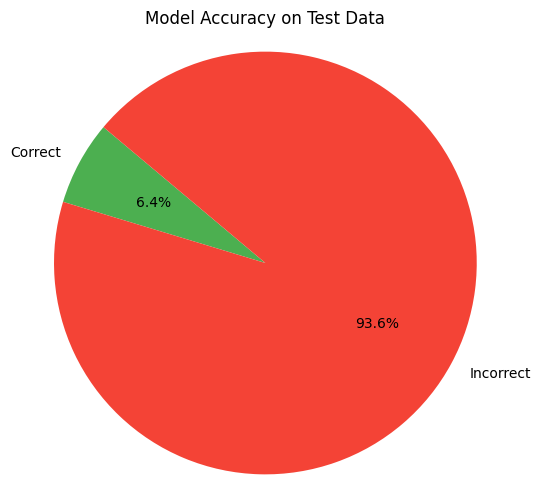

In [32]:
import matplotlib.pyplot as plt

def normalize(ans):
    try:
        return str(round(float(ans), 2))  
    except:
        return None

normalized_preds = [normalize(p) for p in only_predicted_ans]
normalized_truth = [normalize(t) for t in dataset["test"]["final_solution"]]

# Compare
correct = 0
total = len(normalized_preds)

for pred, truth in zip(normalized_preds, normalized_truth):
    if pred == truth:
        correct += 1

incorrect = total - correct

labels = ['Correct', 'Incorrect']
sizes = [correct, incorrect]
colors = ['#4CAF50', '#F44336']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Model Accuracy on Test Data')
plt.axis('equal')
plt.show()
